In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b75'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_b10_b75_roi_t1_mask_t1_nat_k5_b25_k11_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 580)
(878801, 3)
validation
(151459, 580)
(151459, 3)
test
(112754, 580)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 580)]             0         


 dense (Dense)               (None, 2048)              1189888   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 3977475 (15.17 MB)


Trainable params: 3977475 (15.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:06 - loss: 1.3015 - STD: 0.1375 - MAE: 0.4641

2/9 [=====>........................] - ETA: 59s - loss: 1.1743 - STD: 0.1045 - MAE: 0.4491 

3/9 [=========>....................] - ETA: 26s - loss: 1.1625 - STD: 0.1319 - MAE: 0.4390

4/9 [============>.................] - ETA: 15s - loss: 1.1597 - STD: 0.1455 - MAE: 0.4338

5/9 [===============>..............] - ETA: 9s - loss: 1.1543 - STD: 0.1484 - MAE: 0.4313 

6/9 [===================>..........] - ETA: 5s - loss: 1.1467 - STD: 0.1465 - MAE: 0.4304

7/9 [======================>.......] - ETA: 3s - loss: 1.1383 - STD: 0.1412 - MAE: 0.4304

8/9 [=========================>....] - ETA: 1s - loss: 1.1305 - STD: 0.1322 - MAE: 0.4310

9/9 [==============================] - ETA: 0s - loss: 1.1250 - STD: 0.1209 - MAE: 0.4320

9/9 [==============================] - 22s 2s/step - loss: 1.1250 - STD: 0.1209 - MAE: 0.4320 - val_loss: 1.0971 - val_STD: 0.0241 - val_MAE: 0.4434


Epoch 2/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0964 - STD: 0.0242 - MAE: 0.4433

2/9 [=====>........................] - ETA: 2s - loss: 1.1000 - STD: 0.0284 - MAE: 0.4437

3/9 [=========>....................] - ETA: 2s - loss: 1.0990 - STD: 0.0297 - MAE: 0.4435

4/9 [============>.................] - ETA: 1s - loss: 1.0955 - STD: 0.0311 - MAE: 0.4427

5/9 [===============>..............] - ETA: 1s - loss: 1.0915 - STD: 0.0350 - MAE: 0.4416

6/9 [===================>..........] - ETA: 1s - loss: 1.0885 - STD: 0.0411 - MAE: 0.4403

7/9 [======================>.......] - ETA: 0s - loss: 1.0869 - STD: 0.0479 - MAE: 0.4391

8/9 [=========================>....] - ETA: 0s - loss: 1.0861 - STD: 0.0547 - MAE: 0.4380

9/9 [==============================] - ETA: 0s - loss: 1.0859 - STD: 0.0608 - MAE: 0.4370

9/9 [==============================] - 4s 405ms/step - loss: 1.0859 - STD: 0.0608 - MAE: 0.4370 - val_loss: 1.0834 - val_STD: 0.1123 - val_MAE: 0.4281


Epoch 3/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0828 - STD: 0.1123 - MAE: 0.4279

2/9 [=====>........................] - ETA: 2s - loss: 1.0830 - STD: 0.1120 - MAE: 0.4281

3/9 [=========>....................] - ETA: 2s - loss: 1.0818 - STD: 0.1104 - MAE: 0.4283

4/9 [============>.................] - ETA: 1s - loss: 1.0810 - STD: 0.1073 - MAE: 0.4288

5/9 [===============>..............] - ETA: 1s - loss: 1.0797 - STD: 0.1030 - MAE: 0.4295

6/9 [===================>..........] - ETA: 1s - loss: 1.0787 - STD: 0.0978 - MAE: 0.4302

7/9 [======================>.......] - ETA: 0s - loss: 1.0783 - STD: 0.0922 - MAE: 0.4310

8/9 [=========================>....] - ETA: 0s - loss: 1.0781 - STD: 0.0867 - MAE: 0.4318

9/9 [==============================] - ETA: 0s - loss: 1.0780 - STD: 0.0818 - MAE: 0.4325

9/9 [==============================] - 4s 417ms/step - loss: 1.0780 - STD: 0.0818 - MAE: 0.4325 - val_loss: 1.0777 - val_STD: 0.0419 - val_MAE: 0.4382


Epoch 4/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0778 - STD: 0.0419 - MAE: 0.4382

2/9 [=====>........................] - ETA: 2s - loss: 1.0771 - STD: 0.0438 - MAE: 0.4379

3/9 [=========>....................] - ETA: 2s - loss: 1.0765 - STD: 0.0468 - MAE: 0.4374

4/9 [============>.................] - ETA: 1s - loss: 1.0754 - STD: 0.0508 - MAE: 0.4368

5/9 [===============>..............] - ETA: 1s - loss: 1.0750 - STD: 0.0552 - MAE: 0.4362

6/9 [===================>..........] - ETA: 1s - loss: 1.0748 - STD: 0.0595 - MAE: 0.4356

7/9 [======================>.......] - ETA: 0s - loss: 1.0747 - STD: 0.0635 - MAE: 0.4350

8/9 [=========================>....] - ETA: 0s - loss: 1.0745 - STD: 0.0668 - MAE: 0.4344

9/9 [==============================] - ETA: 0s - loss: 1.0744 - STD: 0.0694 - MAE: 0.4340

9/9 [==============================] - 4s 402ms/step - loss: 1.0744 - STD: 0.0694 - MAE: 0.4340 - val_loss: 1.0721 - val_STD: 0.0879 - val_MAE: 0.4309


Epoch 5/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0721 - STD: 0.0880 - MAE: 0.4308

2/9 [=====>........................] - ETA: 2s - loss: 1.0719 - STD: 0.0862 - MAE: 0.4311

3/9 [=========>....................] - ETA: 2s - loss: 1.0714 - STD: 0.0841 - MAE: 0.4313

4/9 [============>.................] - ETA: 1s - loss: 1.0708 - STD: 0.0817 - MAE: 0.4316

5/9 [===============>..............] - ETA: 1s - loss: 1.0703 - STD: 0.0792 - MAE: 0.4318

6/9 [===================>..........] - ETA: 1s - loss: 1.0696 - STD: 0.0769 - MAE: 0.4320

7/9 [======================>.......] - ETA: 0s - loss: 1.0690 - STD: 0.0748 - MAE: 0.4322

8/9 [=========================>....] - ETA: 0s - loss: 1.0683 - STD: 0.0730 - MAE: 0.4322

9/9 [==============================] - ETA: 0s - loss: 1.0673 - STD: 0.0716 - MAE: 0.4322

9/9 [==============================] - 4s 408ms/step - loss: 1.0673 - STD: 0.0716 - MAE: 0.4322 - val_loss: 1.0550 - val_STD: 0.0621 - val_MAE: 0.4306


Epoch 6/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0554 - STD: 0.0627 - MAE: 0.4305

2/9 [=====>........................] - ETA: 2s - loss: 1.0527 - STD: 0.0648 - MAE: 0.4296

3/9 [=========>....................] - ETA: 2s - loss: 1.0493 - STD: 0.0672 - MAE: 0.4285

4/9 [============>.................] - ETA: 1s - loss: 1.0453 - STD: 0.0696 - MAE: 0.4272

5/9 [===============>..............] - ETA: 1s - loss: 1.0412 - STD: 0.0718 - MAE: 0.4257

6/9 [===================>..........] - ETA: 1s - loss: 1.0364 - STD: 0.0740 - MAE: 0.4241

7/9 [======================>.......] - ETA: 0s - loss: 1.0307 - STD: 0.0764 - MAE: 0.4223

8/9 [=========================>....] - ETA: 0s - loss: 1.0240 - STD: 0.0787 - MAE: 0.4202

9/9 [==============================] - ETA: 0s - loss: 1.0166 - STD: 0.0813 - MAE: 0.4179

9/9 [==============================] - 4s 420ms/step - loss: 1.0166 - STD: 0.0813 - MAE: 0.4179 - val_loss: 0.9314 - val_STD: 0.1124 - val_MAE: 0.3904


Epoch 7/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.9314 - STD: 0.1148 - MAE: 0.3898

2/9 [=====>........................] - ETA: 2s - loss: 0.9191 - STD: 0.1198 - MAE: 0.3858

3/9 [=========>....................] - ETA: 2s - loss: 0.9090 - STD: 0.1307 - MAE: 0.3806

4/9 [============>.................] - ETA: 1s - loss: 0.8945 - STD: 0.1383 - MAE: 0.3753

5/9 [===============>..............] - ETA: 1s - loss: 0.8814 - STD: 0.1469 - MAE: 0.3698

6/9 [===================>..........] - ETA: 1s - loss: 0.8719 - STD: 0.1579 - MAE: 0.3640

7/9 [======================>.......] - ETA: 0s - loss: 0.8608 - STD: 0.1668 - MAE: 0.3587

8/9 [=========================>....] - ETA: 0s - loss: 0.8516 - STD: 0.1756 - MAE: 0.3530

9/9 [==============================] - ETA: 0s - loss: 0.8418 - STD: 0.1845 - MAE: 0.3476

9/9 [==============================] - 4s 417ms/step - loss: 0.8418 - STD: 0.1845 - MAE: 0.3476 - val_loss: 0.7932 - val_STD: 0.2512 - val_MAE: 0.3136


Epoch 8/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.7645 - STD: 0.2539 - MAE: 0.3060

2/9 [=====>........................] - ETA: 2s - loss: 0.7556 - STD: 0.2625 - MAE: 0.2990

3/9 [=========>....................] - ETA: 2s - loss: 0.7472 - STD: 0.2641 - MAE: 0.2965

4/9 [============>.................] - ETA: 1s - loss: 0.7437 - STD: 0.2635 - MAE: 0.2962

5/9 [===============>..............] - ETA: 1s - loss: 0.7411 - STD: 0.2669 - MAE: 0.2937

6/9 [===================>..........] - ETA: 1s - loss: 0.7372 - STD: 0.2667 - MAE: 0.2929

7/9 [======================>.......] - ETA: 0s - loss: 0.7332 - STD: 0.2663 - MAE: 0.2925

8/9 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2687 - MAE: 0.2908

9/9 [==============================] - ETA: 0s - loss: 0.7267 - STD: 0.2686 - MAE: 0.2901

9/9 [==============================] - 4s 410ms/step - loss: 0.7267 - STD: 0.2686 - MAE: 0.2901 - val_loss: 0.7069 - val_STD: 0.2649 - val_MAE: 0.2894


Epoch 9/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6881 - STD: 0.2732 - MAE: 0.2808

2/9 [=====>........................] - ETA: 2s - loss: 0.6918 - STD: 0.2823 - MAE: 0.2765

3/9 [=========>....................] - ETA: 2s - loss: 0.6883 - STD: 0.2809 - MAE: 0.2768

4/9 [============>.................] - ETA: 1s - loss: 0.6863 - STD: 0.2806 - MAE: 0.2767

5/9 [===============>..............] - ETA: 1s - loss: 0.6859 - STD: 0.2829 - MAE: 0.2754

6/9 [===================>..........] - ETA: 1s - loss: 0.6838 - STD: 0.2822 - MAE: 0.2753

7/9 [======================>.......] - ETA: 0s - loss: 0.6822 - STD: 0.2816 - MAE: 0.2753

8/9 [=========================>....] - ETA: 0s - loss: 0.6807 - STD: 0.2827 - MAE: 0.2744

9/9 [==============================] - ETA: 0s - loss: 0.6778 - STD: 0.2826 - MAE: 0.2739

9/9 [==============================] - 4s 434ms/step - loss: 0.6778 - STD: 0.2826 - MAE: 0.2739 - val_loss: 0.6585 - val_STD: 0.2791 - val_MAE: 0.2723


Epoch 10/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6550 - STD: 0.2866 - MAE: 0.2670

2/9 [=====>........................] - ETA: 2s - loss: 0.6550 - STD: 0.2921 - MAE: 0.2639

3/9 [=========>....................] - ETA: 2s - loss: 0.6526 - STD: 0.2925 - MAE: 0.2632

4/9 [============>.................] - ETA: 1s - loss: 0.6513 - STD: 0.2941 - MAE: 0.2621

5/9 [===============>..............] - ETA: 1s - loss: 0.6496 - STD: 0.2960 - MAE: 0.2606

6/9 [===================>..........] - ETA: 1s - loss: 0.6481 - STD: 0.2957 - MAE: 0.2605

7/9 [======================>.......] - ETA: 0s - loss: 0.6476 - STD: 0.2966 - MAE: 0.2598

8/9 [=========================>....] - ETA: 0s - loss: 0.6465 - STD: 0.2960 - MAE: 0.2600

9/9 [==============================] - ETA: 0s - loss: 0.6449 - STD: 0.2960 - MAE: 0.2597

9/9 [==============================] - 4s 407ms/step - loss: 0.6449 - STD: 0.2960 - MAE: 0.2597 - val_loss: 0.6098 - val_STD: 0.2950 - val_MAE: 0.2541


Epoch 11/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6345 - STD: 0.3012 - MAE: 0.2543

2/9 [=====>........................] - ETA: 2s - loss: 0.6321 - STD: 0.2991 - MAE: 0.2553

3/9 [=========>....................] - ETA: 2s - loss: 0.6291 - STD: 0.3027 - MAE: 0.2525

4/9 [============>.................] - ETA: 1s - loss: 0.6278 - STD: 0.3037 - MAE: 0.2517

5/9 [===============>..............] - ETA: 1s - loss: 0.6266 - STD: 0.3039 - MAE: 0.2514

6/9 [===================>..........] - ETA: 1s - loss: 0.6252 - STD: 0.3048 - MAE: 0.2505

7/9 [======================>.......] - ETA: 0s - loss: 0.6243 - STD: 0.3041 - MAE: 0.2508

8/9 [=========================>....] - ETA: 0s - loss: 0.6226 - STD: 0.3044 - MAE: 0.2503

9/9 [==============================] - ETA: 0s - loss: 0.6212 - STD: 0.3051 - MAE: 0.2496

9/9 [==============================] - 4s 404ms/step - loss: 0.6212 - STD: 0.3051 - MAE: 0.2496 - val_loss: 0.6002 - val_STD: 0.3065 - val_MAE: 0.2462


Epoch 12/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6094 - STD: 0.3105 - MAE: 0.2442

2/9 [=====>........................] - ETA: 2s - loss: 0.6097 - STD: 0.3142 - MAE: 0.2418

3/9 [=========>....................] - ETA: 2s - loss: 0.6112 - STD: 0.3120 - MAE: 0.2436

4/9 [============>.................] - ETA: 1s - loss: 0.6136 - STD: 0.3140 - MAE: 0.2426

5/9 [===============>..............] - ETA: 1s - loss: 0.6150 - STD: 0.3114 - MAE: 0.2447

6/9 [===================>..........] - ETA: 1s - loss: 0.6137 - STD: 0.3123 - MAE: 0.2437

7/9 [======================>.......] - ETA: 0s - loss: 0.6106 - STD: 0.3126 - MAE: 0.2430

8/9 [=========================>....] - ETA: 0s - loss: 0.6093 - STD: 0.3128 - MAE: 0.2427

9/9 [==============================] - ETA: 0s - loss: 0.6089 - STD: 0.3143 - MAE: 0.2416

9/9 [==============================] - 4s 414ms/step - loss: 0.6089 - STD: 0.3143 - MAE: 0.2416 - val_loss: 0.5847 - val_STD: 0.3110 - val_MAE: 0.2410


Epoch 13/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5964 - STD: 0.3123 - MAE: 0.2410

2/9 [=====>........................] - ETA: 2s - loss: 0.5917 - STD: 0.3119 - MAE: 0.2401

3/9 [=========>....................] - ETA: 2s - loss: 0.5923 - STD: 0.3138 - MAE: 0.2387

4/9 [============>.................] - ETA: 1s - loss: 0.5916 - STD: 0.3137 - MAE: 0.2387

5/9 [===============>..............] - ETA: 1s - loss: 0.5903 - STD: 0.3154 - MAE: 0.2374

6/9 [===================>..........] - ETA: 1s - loss: 0.5882 - STD: 0.3167 - MAE: 0.2361

7/9 [======================>.......] - ETA: 0s - loss: 0.5866 - STD: 0.3172 - MAE: 0.2355

8/9 [=========================>....] - ETA: 0s - loss: 0.5854 - STD: 0.3180 - MAE: 0.2347

9/9 [==============================] - ETA: 0s - loss: 0.5840 - STD: 0.3182 - MAE: 0.2342

9/9 [==============================] - 4s 404ms/step - loss: 0.5840 - STD: 0.3182 - MAE: 0.2342 - val_loss: 0.5403 - val_STD: 0.3192 - val_MAE: 0.2263


Epoch 14/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5749 - STD: 0.3226 - MAE: 0.2295

2/9 [=====>........................] - ETA: 2s - loss: 0.5714 - STD: 0.3235 - MAE: 0.2282

3/9 [=========>....................] - ETA: 2s - loss: 0.5709 - STD: 0.3241 - MAE: 0.2278

4/9 [============>.................] - ETA: 1s - loss: 0.5703 - STD: 0.3253 - MAE: 0.2267

5/9 [===============>..............] - ETA: 1s - loss: 0.5710 - STD: 0.3253 - MAE: 0.2270

6/9 [===================>..........] - ETA: 1s - loss: 0.5711 - STD: 0.3257 - MAE: 0.2267

7/9 [======================>.......] - ETA: 0s - loss: 0.5706 - STD: 0.3254 - MAE: 0.2268

8/9 [=========================>....] - ETA: 0s - loss: 0.5689 - STD: 0.3259 - MAE: 0.2262

9/9 [==============================] - ETA: 0s - loss: 0.5677 - STD: 0.3265 - MAE: 0.2255

9/9 [==============================] - 4s 388ms/step - loss: 0.5677 - STD: 0.3265 - MAE: 0.2255 - val_loss: 0.5547 - val_STD: 0.3273 - val_MAE: 0.2250


Epoch 15/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5604 - STD: 0.3305 - MAE: 0.2218

2/9 [=====>........................] - ETA: 2s - loss: 0.5673 - STD: 0.3317 - MAE: 0.2219

3/9 [=========>....................] - ETA: 2s - loss: 0.5711 - STD: 0.3304 - MAE: 0.2239

4/9 [============>.................] - ETA: 1s - loss: 0.5696 - STD: 0.3308 - MAE: 0.2231

5/9 [===============>..............] - ETA: 1s - loss: 0.5656 - STD: 0.3308 - MAE: 0.2222

6/9 [===================>..........] - ETA: 1s - loss: 0.5648 - STD: 0.3312 - MAE: 0.2219

7/9 [======================>.......] - ETA: 0s - loss: 0.5667 - STD: 0.3322 - MAE: 0.2216

8/9 [=========================>....] - ETA: 0s - loss: 0.5649 - STD: 0.3320 - MAE: 0.2214

9/9 [==============================] - ETA: 0s - loss: 0.5636 - STD: 0.3319 - MAE: 0.2211

9/9 [==============================] - 4s 392ms/step - loss: 0.5636 - STD: 0.3319 - MAE: 0.2211 - val_loss: 0.5064 - val_STD: 0.3302 - val_MAE: 0.2114


Epoch 16/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5629 - STD: 0.3365 - MAE: 0.2176

2/9 [=====>........................] - ETA: 2s - loss: 0.5559 - STD: 0.3359 - MAE: 0.2168

3/9 [=========>....................] - ETA: 2s - loss: 0.5532 - STD: 0.3357 - MAE: 0.2165

4/9 [============>.................] - ETA: 1s - loss: 0.5542 - STD: 0.3361 - MAE: 0.2164

5/9 [===============>..............] - ETA: 1s - loss: 0.5515 - STD: 0.3354 - MAE: 0.2163

6/9 [===================>..........] - ETA: 0s - loss: 0.5500 - STD: 0.3352 - MAE: 0.2161

7/9 [======================>.......] - ETA: 0s - loss: 0.5499 - STD: 0.3358 - MAE: 0.2157

8/9 [=========================>....] - ETA: 0s - loss: 0.5482 - STD: 0.3363 - MAE: 0.2150

9/9 [==============================] - ETA: 0s - loss: 0.5474 - STD: 0.3365 - MAE: 0.2147

9/9 [==============================] - 4s 410ms/step - loss: 0.5474 - STD: 0.3365 - MAE: 0.2147 - val_loss: 0.4983 - val_STD: 0.3334 - val_MAE: 0.2080


Epoch 17/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5466 - STD: 0.3372 - MAE: 0.2137

2/9 [=====>........................] - ETA: 2s - loss: 0.5400 - STD: 0.3370 - MAE: 0.2126

3/9 [=========>....................] - ETA: 2s - loss: 0.5399 - STD: 0.3380 - MAE: 0.2121

4/9 [============>.................] - ETA: 1s - loss: 0.5399 - STD: 0.3391 - MAE: 0.2112

5/9 [===============>..............] - ETA: 1s - loss: 0.5384 - STD: 0.3396 - MAE: 0.2107

6/9 [===================>..........] - ETA: 1s - loss: 0.5364 - STD: 0.3396 - MAE: 0.2103

7/9 [======================>.......] - ETA: 0s - loss: 0.5367 - STD: 0.3398 - MAE: 0.2101

8/9 [=========================>....] - ETA: 0s - loss: 0.5367 - STD: 0.3402 - MAE: 0.2098

9/9 [==============================] - ETA: 0s - loss: 0.5354 - STD: 0.3405 - MAE: 0.2094

9/9 [==============================] - 4s 407ms/step - loss: 0.5354 - STD: 0.3405 - MAE: 0.2094 - val_loss: 0.4916 - val_STD: 0.3393 - val_MAE: 0.2029


Epoch 18/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5311 - STD: 0.3418 - MAE: 0.2073

2/9 [=====>........................] - ETA: 2s - loss: 0.5329 - STD: 0.3426 - MAE: 0.2073

3/9 [=========>....................] - ETA: 2s - loss: 0.5308 - STD: 0.3426 - MAE: 0.2069

4/9 [============>.................] - ETA: 1s - loss: 0.5286 - STD: 0.3425 - MAE: 0.2065

5/9 [===============>..............] - ETA: 1s - loss: 0.5289 - STD: 0.3428 - MAE: 0.2063

6/9 [===================>..........] - ETA: 1s - loss: 0.5291 - STD: 0.3431 - MAE: 0.2061

7/9 [======================>.......] - ETA: 0s - loss: 0.5278 - STD: 0.3435 - MAE: 0.2055

8/9 [=========================>....] - ETA: 0s - loss: 0.5265 - STD: 0.3438 - MAE: 0.2051

9/9 [==============================] - ETA: 0s - loss: 0.5263 - STD: 0.3440 - MAE: 0.2049

9/9 [==============================] - 4s 403ms/step - loss: 0.5263 - STD: 0.3440 - MAE: 0.2049 - val_loss: 0.5276 - val_STD: 0.3465 - val_MAE: 0.2064


Epoch 19/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5216 - STD: 0.3476 - MAE: 0.2016

2/9 [=====>........................] - ETA: 2s - loss: 0.5188 - STD: 0.3469 - MAE: 0.2013

3/9 [=========>....................] - ETA: 2s - loss: 0.5172 - STD: 0.3469 - MAE: 0.2009

4/9 [============>.................] - ETA: 1s - loss: 0.5167 - STD: 0.3474 - MAE: 0.2004

5/9 [===============>..............] - ETA: 1s - loss: 0.5162 - STD: 0.3474 - MAE: 0.2003

6/9 [===================>..........] - ETA: 1s - loss: 0.5150 - STD: 0.3475 - MAE: 0.2000

7/9 [======================>.......] - ETA: 0s - loss: 0.5148 - STD: 0.3475 - MAE: 0.1999

8/9 [=========================>....] - ETA: 0s - loss: 0.5148 - STD: 0.3475 - MAE: 0.1999

9/9 [==============================] - ETA: 0s - loss: 0.5149 - STD: 0.3477 - MAE: 0.1997

9/9 [==============================] - 4s 434ms/step - loss: 0.5149 - STD: 0.3477 - MAE: 0.1997 - val_loss: 0.4755 - val_STD: 0.3463 - val_MAE: 0.1947


Epoch 20/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5110 - STD: 0.3471 - MAE: 0.1990

2/9 [=====>........................] - ETA: 2s - loss: 0.5066 - STD: 0.3478 - MAE: 0.1977

3/9 [=========>....................] - ETA: 2s - loss: 0.5051 - STD: 0.3489 - MAE: 0.1967

4/9 [============>.................] - ETA: 1s - loss: 0.5038 - STD: 0.3492 - MAE: 0.1962

5/9 [===============>..............] - ETA: 1s - loss: 0.5031 - STD: 0.3492 - MAE: 0.1960

6/9 [===================>..........] - ETA: 1s - loss: 0.5017 - STD: 0.3495 - MAE: 0.1955

7/9 [======================>.......] - ETA: 0s - loss: 0.5012 - STD: 0.3500 - MAE: 0.1951

8/9 [=========================>....] - ETA: 0s - loss: 0.5007 - STD: 0.3504 - MAE: 0.1946

9/9 [==============================] - ETA: 0s - loss: 0.5003 - STD: 0.3503 - MAE: 0.1946

9/9 [==============================] - 4s 415ms/step - loss: 0.5003 - STD: 0.3503 - MAE: 0.1946 - val_loss: 0.5025 - val_STD: 0.3551 - val_MAE: 0.1948


Epoch 21/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4965 - STD: 0.3564 - MAE: 0.1894

2/9 [=====>........................] - ETA: 2s - loss: 0.4977 - STD: 0.3536 - MAE: 0.1916

3/9 [=========>....................] - ETA: 2s - loss: 0.4965 - STD: 0.3534 - MAE: 0.1915

4/9 [============>.................] - ETA: 1s - loss: 0.4952 - STD: 0.3530 - MAE: 0.1915

5/9 [===============>..............] - ETA: 1s - loss: 0.4936 - STD: 0.3540 - MAE: 0.1905

6/9 [===================>..........] - ETA: 1s - loss: 0.4928 - STD: 0.3533 - MAE: 0.1908

7/9 [======================>.......] - ETA: 0s - loss: 0.4914 - STD: 0.3542 - MAE: 0.1899

8/9 [=========================>....] - ETA: 0s - loss: 0.4899 - STD: 0.3543 - MAE: 0.1894

9/9 [==============================] - ETA: 0s - loss: 0.4882 - STD: 0.3544 - MAE: 0.1890

9/9 [==============================] - 4s 413ms/step - loss: 0.4882 - STD: 0.3544 - MAE: 0.1890 - val_loss: 0.4657 - val_STD: 0.3574 - val_MAE: 0.1853


Epoch 22/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4740 - STD: 0.3583 - MAE: 0.1833

2/9 [=====>........................] - ETA: 2s - loss: 0.4736 - STD: 0.3573 - MAE: 0.1839

3/9 [=========>....................] - ETA: 2s - loss: 0.4749 - STD: 0.3584 - MAE: 0.1834

4/9 [============>.................] - ETA: 1s - loss: 0.4796 - STD: 0.3568 - MAE: 0.1856

5/9 [===============>..............] - ETA: 1s - loss: 0.4838 - STD: 0.3592 - MAE: 0.1849

6/9 [===================>..........] - ETA: 1s - loss: 0.4847 - STD: 0.3584 - MAE: 0.1857

7/9 [======================>.......] - ETA: 0s - loss: 0.4824 - STD: 0.3587 - MAE: 0.1849

8/9 [=========================>....] - ETA: 0s - loss: 0.4809 - STD: 0.3594 - MAE: 0.1840

9/9 [==============================] - ETA: 0s - loss: 0.4812 - STD: 0.3591 - MAE: 0.1843

9/9 [==============================] - 4s 394ms/step - loss: 0.4812 - STD: 0.3591 - MAE: 0.1843 - val_loss: 0.4817 - val_STD: 0.3620 - val_MAE: 0.1854


Epoch 23/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4634 - STD: 0.3629 - MAE: 0.1778

2/9 [=====>........................] - ETA: 2s - loss: 0.4619 - STD: 0.3622 - MAE: 0.1779

3/9 [=========>....................] - ETA: 1s - loss: 0.4625 - STD: 0.3609 - MAE: 0.1791

4/9 [============>.................] - ETA: 1s - loss: 0.4618 - STD: 0.3620 - MAE: 0.1783

5/9 [===============>..............] - ETA: 1s - loss: 0.4604 - STD: 0.3613 - MAE: 0.1785

6/9 [===================>..........] - ETA: 1s - loss: 0.4593 - STD: 0.3614 - MAE: 0.1783

7/9 [======================>.......] - ETA: 0s - loss: 0.4582 - STD: 0.3618 - MAE: 0.1777

8/9 [=========================>....] - ETA: 0s - loss: 0.4579 - STD: 0.3614 - MAE: 0.1780

9/9 [==============================] - ETA: 0s - loss: 0.4577 - STD: 0.3624 - MAE: 0.1773

9/9 [==============================] - 4s 420ms/step - loss: 0.4577 - STD: 0.3624 - MAE: 0.1773 - val_loss: 0.4467 - val_STD: 0.3657 - val_MAE: 0.1759


Epoch 24/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4474 - STD: 0.3624 - MAE: 0.1750

2/9 [=====>........................] - ETA: 2s - loss: 0.4451 - STD: 0.3637 - MAE: 0.1737

3/9 [=========>....................] - ETA: 2s - loss: 0.4444 - STD: 0.3657 - MAE: 0.1722

4/9 [============>.................] - ETA: 1s - loss: 0.4439 - STD: 0.3657 - MAE: 0.1721

5/9 [===============>..............] - ETA: 1s - loss: 0.4430 - STD: 0.3664 - MAE: 0.1714

6/9 [===================>..........] - ETA: 0s - loss: 0.4448 - STD: 0.3664 - MAE: 0.1718

7/9 [======================>.......] - ETA: 0s - loss: 0.4467 - STD: 0.3674 - MAE: 0.1715

8/9 [=========================>....] - ETA: 0s - loss: 0.4497 - STD: 0.3670 - MAE: 0.1725

9/9 [==============================] - ETA: 0s - loss: 0.4521 - STD: 0.3680 - MAE: 0.1722

9/9 [==============================] - 4s 397ms/step - loss: 0.4521 - STD: 0.3680 - MAE: 0.1722 - val_loss: 0.4249 - val_STD: 0.3730 - val_MAE: 0.1665


Epoch 25/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4500 - STD: 0.3689 - MAE: 0.1712

2/9 [=====>........................] - ETA: 2s - loss: 0.4392 - STD: 0.3698 - MAE: 0.1683

3/9 [=========>....................] - ETA: 2s - loss: 0.4408 - STD: 0.3710 - MAE: 0.1678

4/9 [============>.................] - ETA: 1s - loss: 0.4449 - STD: 0.3701 - MAE: 0.1695

5/9 [===============>..............] - ETA: 1s - loss: 0.4432 - STD: 0.3710 - MAE: 0.1684

6/9 [===================>..........] - ETA: 1s - loss: 0.4402 - STD: 0.3709 - MAE: 0.1679

7/9 [======================>.......] - ETA: 0s - loss: 0.4408 - STD: 0.3703 - MAE: 0.1684

8/9 [=========================>....] - ETA: 0s - loss: 0.4421 - STD: 0.3710 - MAE: 0.1683

9/9 [==============================] - ETA: 0s - loss: 0.4405 - STD: 0.3705 - MAE: 0.1684

9/9 [==============================] - 4s 410ms/step - loss: 0.4405 - STD: 0.3705 - MAE: 0.1684 - val_loss: 0.4321 - val_STD: 0.3714 - val_MAE: 0.1687


Epoch 26/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4205 - STD: 0.3689 - MAE: 0.1653

2/9 [=====>........................] - ETA: 2s - loss: 0.4261 - STD: 0.3714 - MAE: 0.1648

3/9 [=========>....................] - ETA: 2s - loss: 0.4274 - STD: 0.3700 - MAE: 0.1661

4/9 [============>.................] - ETA: 1s - loss: 0.4264 - STD: 0.3704 - MAE: 0.1656

5/9 [===============>..............] - ETA: 1s - loss: 0.4249 - STD: 0.3709 - MAE: 0.1649

6/9 [===================>..........] - ETA: 1s - loss: 0.4245 - STD: 0.3708 - MAE: 0.1649

7/9 [======================>.......] - ETA: 0s - loss: 0.4259 - STD: 0.3716 - MAE: 0.1646

8/9 [=========================>....] - ETA: 0s - loss: 0.4258 - STD: 0.3717 - MAE: 0.1645

9/9 [==============================] - ETA: 0s - loss: 0.4245 - STD: 0.3722 - MAE: 0.1639

9/9 [==============================] - 4s 395ms/step - loss: 0.4245 - STD: 0.3722 - MAE: 0.1639 - val_loss: 0.4401 - val_STD: 0.3753 - val_MAE: 0.1670


Epoch 27/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4139 - STD: 0.3755 - MAE: 0.1593

2/9 [=====>........................] - ETA: 2s - loss: 0.4175 - STD: 0.3740 - MAE: 0.1613

3/9 [=========>....................] - ETA: 2s - loss: 0.4197 - STD: 0.3754 - MAE: 0.1606

4/9 [============>.................] - ETA: 1s - loss: 0.4197 - STD: 0.3747 - MAE: 0.1612

5/9 [===============>..............] - ETA: 1s - loss: 0.4172 - STD: 0.3748 - MAE: 0.1606

6/9 [===================>..........] - ETA: 1s - loss: 0.4153 - STD: 0.3750 - MAE: 0.1601

7/9 [======================>.......] - ETA: 0s - loss: 0.4140 - STD: 0.3749 - MAE: 0.1599

8/9 [=========================>....] - ETA: 0s - loss: 0.4136 - STD: 0.3753 - MAE: 0.1596

9/9 [==============================] - ETA: 0s - loss: 0.4131 - STD: 0.3753 - MAE: 0.1594

9/9 [==============================] - 4s 398ms/step - loss: 0.4131 - STD: 0.3753 - MAE: 0.1594 - val_loss: 0.4296 - val_STD: 0.3790 - val_MAE: 0.1618


Epoch 28/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4081 - STD: 0.3796 - MAE: 0.1553

2/9 [=====>........................] - ETA: 2s - loss: 0.4093 - STD: 0.3782 - MAE: 0.1565

3/9 [=========>....................] - ETA: 2s - loss: 0.4094 - STD: 0.3793 - MAE: 0.1557

4/9 [============>.................] - ETA: 1s - loss: 0.4111 - STD: 0.3788 - MAE: 0.1565

5/9 [===============>..............] - ETA: 1s - loss: 0.4142 - STD: 0.3796 - MAE: 0.1565

6/9 [===================>..........] - ETA: 1s - loss: 0.4174 - STD: 0.3791 - MAE: 0.1577

7/9 [======================>.......] - ETA: 0s - loss: 0.4236 - STD: 0.3801 - MAE: 0.1581

8/9 [=========================>....] - ETA: 0s - loss: 0.4255 - STD: 0.3797 - MAE: 0.1588

9/9 [==============================] - ETA: 0s - loss: 0.4236 - STD: 0.3802 - MAE: 0.1581

9/9 [==============================] - 4s 415ms/step - loss: 0.4236 - STD: 0.3802 - MAE: 0.1581 - val_loss: 0.4352 - val_STD: 0.3820 - val_MAE: 0.1607


Epoch 29/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4021 - STD: 0.3826 - MAE: 0.1516

2/9 [=====>........................] - ETA: 2s - loss: 0.4130 - STD: 0.3804 - MAE: 0.1554

3/9 [=========>....................] - ETA: 2s - loss: 0.4157 - STD: 0.3819 - MAE: 0.1549

4/9 [============>.................] - ETA: 1s - loss: 0.4124 - STD: 0.3811 - MAE: 0.1549

5/9 [===============>..............] - ETA: 1s - loss: 0.4097 - STD: 0.3805 - MAE: 0.1548

6/9 [===================>..........] - ETA: 1s - loss: 0.4104 - STD: 0.3805 - MAE: 0.1550

7/9 [======================>.......] - ETA: 0s - loss: 0.4113 - STD: 0.3796 - MAE: 0.1558

8/9 [=========================>....] - ETA: 0s - loss: 0.4103 - STD: 0.3793 - MAE: 0.1558

9/9 [==============================] - ETA: 0s - loss: 0.4089 - STD: 0.3790 - MAE: 0.1558

9/9 [==============================] - 4s 419ms/step - loss: 0.4089 - STD: 0.3790 - MAE: 0.1558 - val_loss: 0.4133 - val_STD: 0.3798 - val_MAE: 0.1588


Epoch 30/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4015 - STD: 0.3751 - MAE: 0.1573

2/9 [=====>........................] - ETA: 1s - loss: 0.4017 - STD: 0.3770 - MAE: 0.1558

3/9 [=========>....................] - ETA: 1s - loss: 0.4007 - STD: 0.3769 - MAE: 0.1557

4/9 [============>.................] - ETA: 1s - loss: 0.3989 - STD: 0.3772 - MAE: 0.1551

5/9 [===============>..............] - ETA: 1s - loss: 0.3983 - STD: 0.3782 - MAE: 0.1543

6/9 [===================>..........] - ETA: 1s - loss: 0.3982 - STD: 0.3782 - MAE: 0.1543

7/9 [======================>.......] - ETA: 0s - loss: 0.3976 - STD: 0.3788 - MAE: 0.1537

8/9 [=========================>....] - ETA: 0s - loss: 0.3968 - STD: 0.3792 - MAE: 0.1533

9/9 [==============================] - ETA: 0s - loss: 0.3962 - STD: 0.3793 - MAE: 0.1530

9/9 [==============================] - 4s 411ms/step - loss: 0.3962 - STD: 0.3793 - MAE: 0.1530 - val_loss: 0.4264 - val_STD: 0.3815 - val_MAE: 0.1589


Epoch 31/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3963 - STD: 0.3821 - MAE: 0.1509

2/9 [=====>........................] - ETA: 1s - loss: 0.3944 - STD: 0.3813 - MAE: 0.1512

3/9 [=========>....................] - ETA: 1s - loss: 0.3923 - STD: 0.3814 - MAE: 0.1507

4/9 [============>.................] - ETA: 1s - loss: 0.3915 - STD: 0.3816 - MAE: 0.1504

5/9 [===============>..............] - ETA: 1s - loss: 0.3911 - STD: 0.3813 - MAE: 0.1506

6/9 [===================>..........] - ETA: 1s - loss: 0.3918 - STD: 0.3815 - MAE: 0.1505

7/9 [======================>.......] - ETA: 0s - loss: 0.3914 - STD: 0.3815 - MAE: 0.1504

8/9 [=========================>....] - ETA: 0s - loss: 0.3910 - STD: 0.3817 - MAE: 0.1502

9/9 [==============================] - ETA: 0s - loss: 0.3907 - STD: 0.3819 - MAE: 0.1500

9/9 [==============================] - 4s 418ms/step - loss: 0.3907 - STD: 0.3819 - MAE: 0.1500 - val_loss: 0.4136 - val_STD: 0.3854 - val_MAE: 0.1532


Epoch 32/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3862 - STD: 0.3854 - MAE: 0.1465

2/9 [=====>........................] - ETA: 2s - loss: 0.3853 - STD: 0.3847 - MAE: 0.1469

3/9 [=========>....................] - ETA: 2s - loss: 0.3845 - STD: 0.3852 - MAE: 0.1463

4/9 [============>.................] - ETA: 1s - loss: 0.3849 - STD: 0.3855 - MAE: 0.1461

5/9 [===============>..............] - ETA: 1s - loss: 0.3850 - STD: 0.3855 - MAE: 0.1461

6/9 [===================>..........] - ETA: 1s - loss: 0.3851 - STD: 0.3858 - MAE: 0.1459

7/9 [======================>.......] - ETA: 0s - loss: 0.3860 - STD: 0.3855 - MAE: 0.1464

8/9 [=========================>....] - ETA: 0s - loss: 0.3892 - STD: 0.3858 - MAE: 0.1469

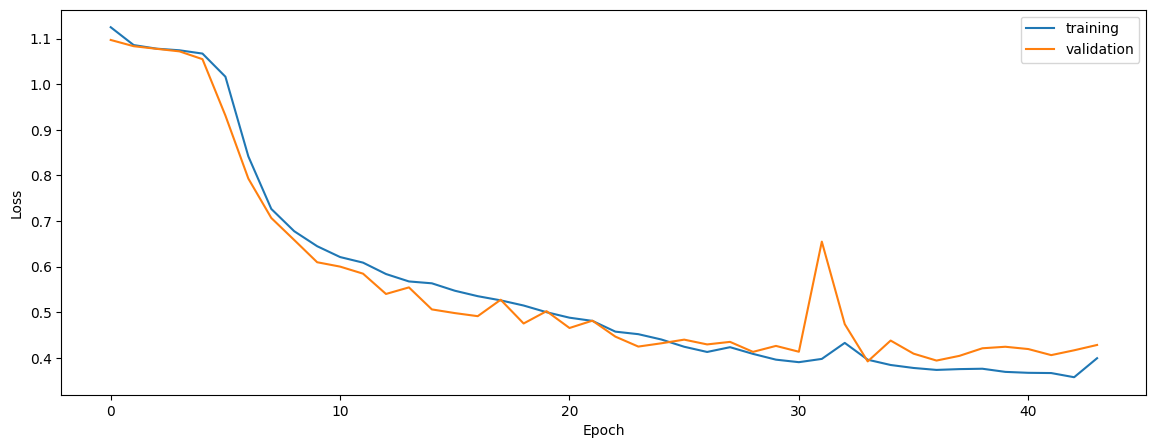

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8455099618685004


0.8371308406895596


0.842054383879951


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.859174926491511


0.8382483143771708


0.8470495999262112


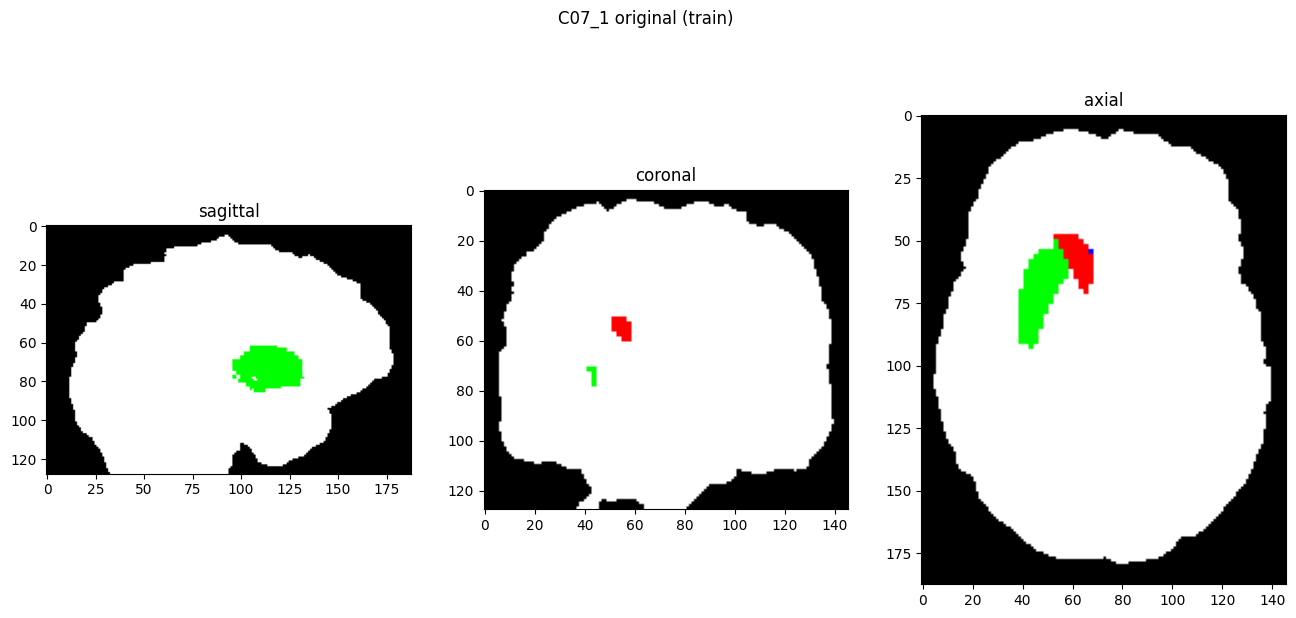

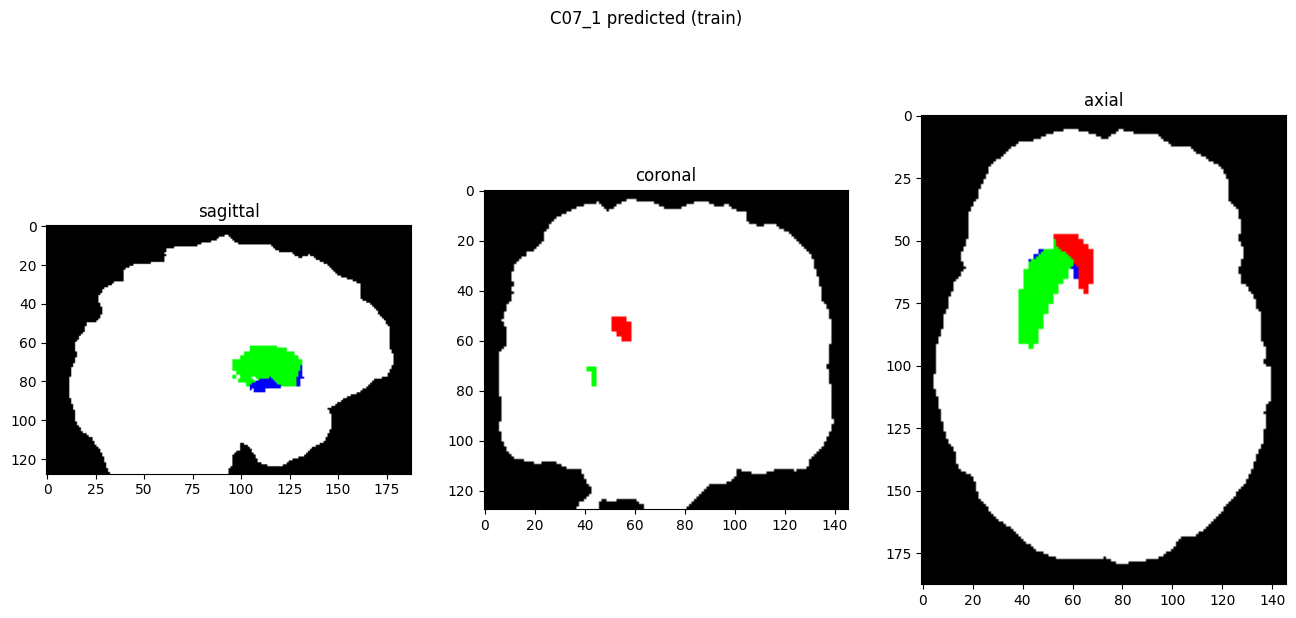

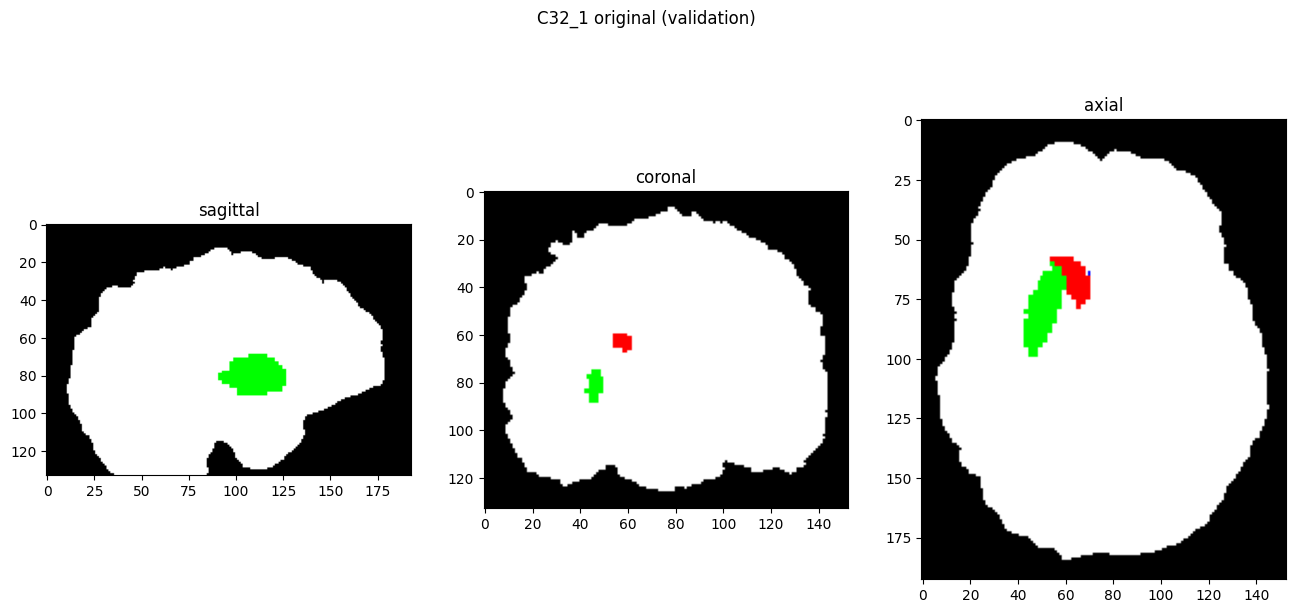

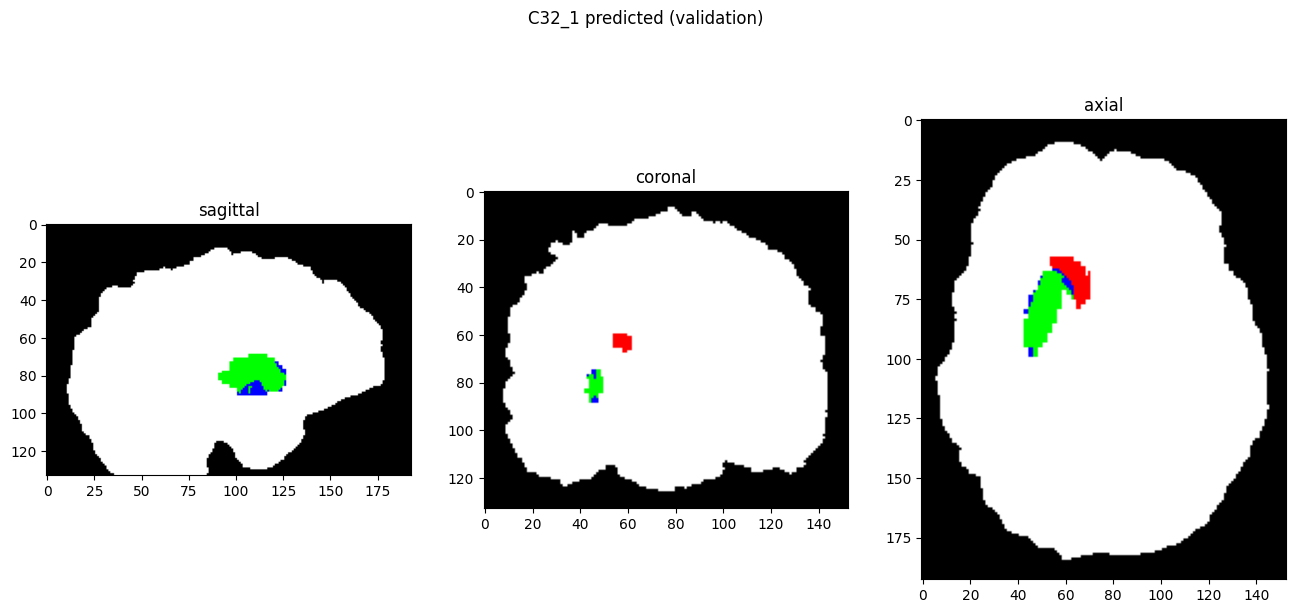

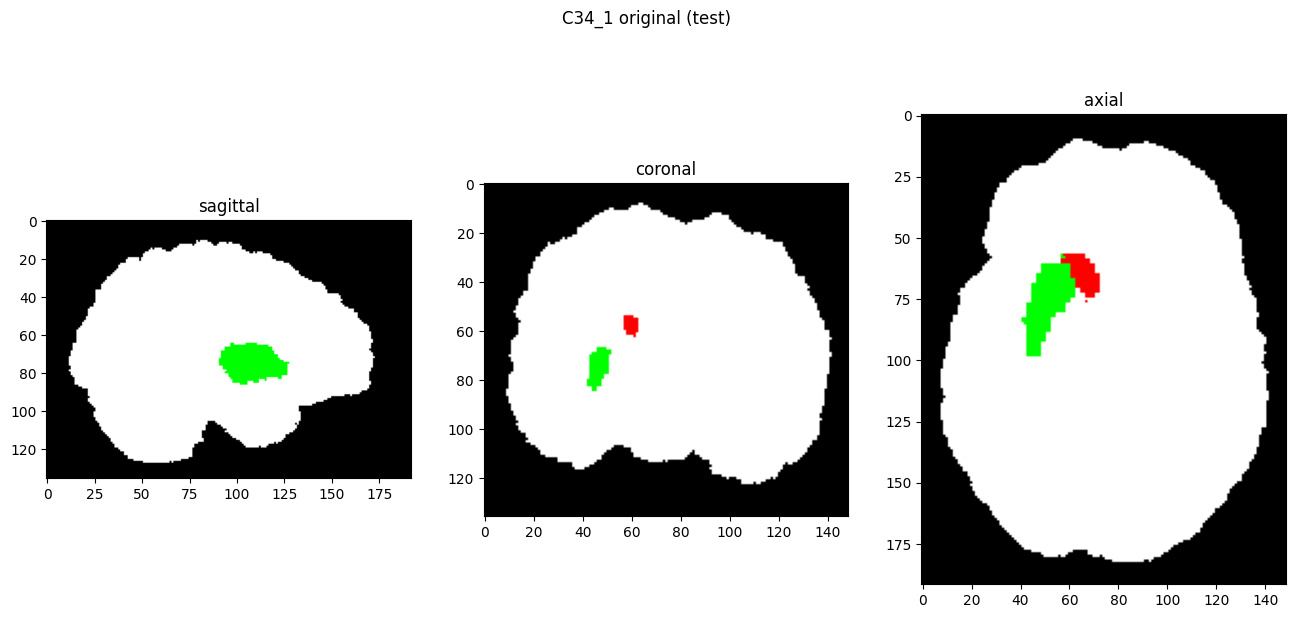

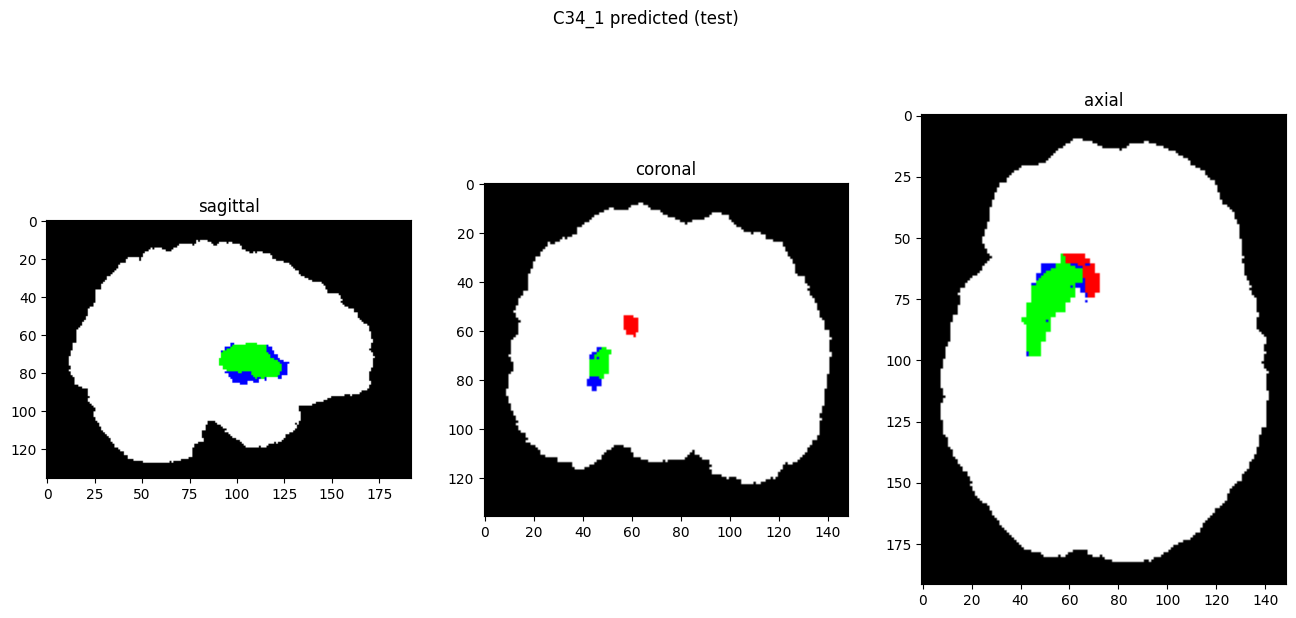

In [9]:
showResults(model, gen, threshold=0)